In [2]:
from IPython.core.display import HTML
import plotly
import plotly.graph_objects as go
import noise
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline

In [7]:
help(noise.pnoise3)
print('Help for pnoise 2\n')
help(noise.pnoise2)

Help on built-in function noise3 in module noise._perlin:

noise3(...)
    noise3(x, y, z, octaves=1, persistence=0.5, lacunarity=2.0repeatx=1024, repeaty=1024, repeatz=1024, base=0.0)
    
    return perlin "improved" noise value for specified coordinate
    
    octaves -- specifies the number of passes for generating fBm noise,
    defaults to 1 (simple noise).
    
    persistence -- specifies the amplitude of each successive octave relative
    to the one below it. Defaults to 0.5 (each higher octave's amplitude
    is halved). Note the amplitude of the first pass is always 1.0.
    
    lacunarity -- specifies the frequency of each successive octave relative
    to the one below it, similar to persistence. Defaults to 2.0.
    
    repeatx, repeaty, repeatz -- specifies the interval along each axis when 
    the noise values repeat. This can be used as the tile size for creating 
    tileable textures
    
    base -- specifies a fixed offset for the input coordinates. Useful for

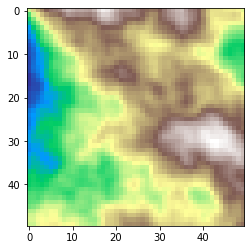

In [8]:
# Using Perlin Noise to make a terrain
# https://en.wikipedia.org/wiki/Perlin_noise
shape = (50,50)
scale = 100.0
octaves = 6
persistence = 0.5
lacunarity = 2.0

world = np.zeros(shape)
for i in range(shape[0]):
    for j in range(shape[1]):
        world[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=42)
        
plt.imshow(world, cmap='terrain') # Terrain based IMSHOW

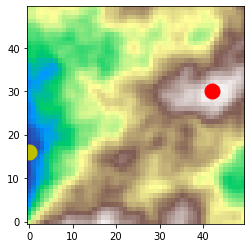

In [11]:
z = world
plt.imshow(z,origin='lower',cmap='terrain')

# Find maximum value index in numpy array
indices = np.where(z == z.max())
max_z_x_location, max_z_y_location = (indices[1][0],indices[0][0])
plt.plot(max_z_x_location,max_z_y_location,'ro',markersize=15)

# Find minimum value index in numpy array
indices = np.where(z == z.min())
min_z_x_location, min_z_y_location = (indices[1][0],indices[0][0])
plt.plot(min_z_x_location,min_z_y_location,'yo',markersize=15)

Instead of computing the gradient at each point, here we evaluate the np array by searching through the neighbouring values

Source: https://stackoverflow.com/questions/10996769/pixel-neighbors-in-2d-array-image-using-python

In [12]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def sliding_window(arr, window_size):
    """ Construct a sliding window view of the array"""
    arr = np.asarray(arr)
    window_size = int(window_size)
    if arr.ndim != 2:
        raise ValueError("need 2-D input")
    if not (window_size > 0):
        raise ValueError("need a positive window size")
    shape = (arr.shape[0] - window_size + 1,
             arr.shape[1] - window_size + 1,
             window_size, window_size)
    if shape[0] <= 0:
        shape = (1, shape[1], arr.shape[0], shape[3])
    if shape[1] <= 0:
        shape = (shape[0], 1, shape[2], arr.shape[1])
    strides = (arr.shape[1]*arr.itemsize, arr.itemsize,
               arr.shape[1]*arr.itemsize, arr.itemsize)
    return as_strided(arr, shape=shape, strides=strides)

def cell_neighbours(arr, i, j, d):
    """Return d-th neighbors of cell (i, j)"""
    w = sliding_window(arr, 2*d+1)

    ix = np.clip(i - d, 0, w.shape[0]-1)
    jx = np.clip(j - d, 0, w.shape[1]-1)

    i0 = max(0, i - d - ix)
    j0 = max(0, j - d - jx)
    i1 = w.shape[2] - max(0, d - i + ix)
    j1 = w.shape[3] - max(0, d - j + jx)

    return w[ix, jx][i0:i1,j0:j1].ravel()

In [13]:
from dataclasses import dataclass

@dataclass
class descent_step:
    '''Class of storing each step taken in gradient descent'''
    value: float
    x_index: float
    y_index: float
    
def gradient_descent_3D(array, x_start, y_start, steps=50, step_size=1, plot=False):
    # Initial point to start gradient descent in a list
    step = descent_step(array[y_start][x_start], x_start, y_start)
    
    # Store each step taken in gradient descent in a list
    step_history = []
    step_history.append(step)
    
    # Plot 2D representation of array with starting point
    if plot:
        plt.imshow(array, origin='lower', cmap='terrain')
        plt.plot(x_start, y_start, 'ro')
    
    current_x = x_start
    current_y = y_start
    
    # Iterate through the steps for Gradient Descent
    for i in range(steps):
        prev_x = current_x
        prev_y = current_y
        
        # Extract array of neighbouring cells around current step location with size nominated
        neighbours=cell_neighbours(array,current_y,current_x,step_size)
        
        # Locate minimum in array (steepest slope from current point)
        next_step = neighbours.min()
        indices = np.where(array == next_step)
        
        # Update current point to now be the next point after stepping
        current_x, current_y = (indices[1][0],indices[0][0])
        step = descent_step(array[current_y][current_x],current_x,current_y)
        
        step_history.append(step)
        
        # Plot each step taken as a black line to the current point nominated by a red marker
        if plot:
            matplotlib.pyplot.plot([prev_x,current_x],[prev_y,current_y],'k-')
            matplotlib.pyplot.plot(current_x,current_y,'ro')
            
        # If step is to the same location as previously, this infers convergence and end loop
        if prev_y == current_y and prev_x == current_x:
            print(f"Converged in {i} steps")
            break
    return next_step,step_history

Target: -0.0994970053434372 @ (array([16], dtype=int64), array([0], dtype=int64))
Converged in 6 steps
Converged in 3 steps
Converged in 2 steps
Converged in 6 steps
Optimal step size 4
Converged in 6 steps
Steps: [descent_step(value=0.025035260245203972, x_index=23, y_index=28), descent_step(value=0.002499207155779004, x_index=19, y_index=24), descent_step(value=-0.012357883155345917, x_index=15, y_index=22), descent_step(value=-0.02639753557741642, x_index=11, y_index=21), descent_step(value=-0.052490122616291046, x_index=7, y_index=20), descent_step(value=-0.08205940574407578, x_index=3, y_index=17), descent_step(value=-0.0994970053434372, x_index=0, y_index=16), descent_step(value=-0.0994970053434372, x_index=0, y_index=16)]


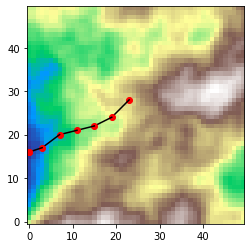

In [15]:
np.random.seed(1337)
global_min = z.min()
indices = np.where(z == global_min)

print(f'Target: {global_min} @ {indices}')

step_size = 0
found_min = 99999

# Starting point
start_x = np.random.randint(0, 50)
start_y = np.random.randint(0, 50)

# Increase step size until convergence on global minimum
while found_min != global_min:
    step_size += 1
    found_min, steps = gradient_descent_3D(z, start_x,start_y,step_size=step_size,plot=False)

print(f"Optimal step size {step_size}")
found_min,steps = gradient_descent_3D(z,start_x,start_y,step_size=step_size,plot=True)
print(f"Steps: {steps}")

Moving from each point to the next is typically represented as a vector, in our case, this will be in 3D space. In 2D space, you would use a quiver plot to show this, in 3D, you can use a Cone Plot.

In [17]:
# Source https://stackoverflow.com/questions/51272288/how-to-calculate-the-vector-from-two-points-in-3d-with-python

def multiDimenDist(point1,point2):
    #find the difference between the two points, its really the same as below
    deltaVals = [point2[dimension]-point1[dimension] for dimension in range(len(point1))]
    runningSquared = 0
    #because the pythagarom theorm works for any dimension we can just use that
    for coOrd in deltaVals:
        runningSquared += coOrd**2
    return runningSquared**(1/2)


def findVec(point1,point2,unitSphere = False):
    #setting unitSphere to True will make the vector scaled down to a sphere with a radius one, instead of it's orginal length
    finalVector = [0 for coOrd in point1]
    for dimension, coOrd in enumerate(point1):
        #finding total differnce for that co-ordinate(x,y,z...)
        deltaCoOrd = point2[dimension]-coOrd
        #adding total difference
        finalVector[dimension] = deltaCoOrd
    if unitSphere:
        totalDist = multiDimenDist(point1,point2)
        unitVector =[]
        for dim in finalVector:
            unitVector.append(dim / totalDist)
        return unitVector
    else:
        return finalVector

In [20]:
# Generate 3D plots
def generate_3D_plot(step_history):
    # Initialise empty lists for markers
    step_markers_x = []
    step_markers_y = []
    step_markers_z = []
    step_markers_u = []
    step_markers_v = []
    step_markers_w = []
    
    for index, step in enumerate(step_history):
        step_markers_x.append(step.x_index)
        step_markers_y.append(step.y_index)
        step_markers_z.append(step.value)
        
        # If we haven't reached the final step, calculate the vector between the current step and the next step
        if index < len(steps)-1:
            vec1 = [step.x_index,step.y_index,step.value]
            vec2 = [steps[index+1].x_index,steps[index+1].y_index,steps[index+1].value]

            result_vector = findVec(vec1,vec2)
            step_markers_u.append(result_vector[0])
            step_markers_v.append(result_vector[1])
            step_markers_w.append(result_vector[2])
        else:
            step_markers_u.append(0.1)
            step_markers_v.append(0.1)
            step_markers_w.append(0.1)
    
    # Include cones at each marker to show direction of step, scatter3d is to show the red line between points 
    # and surface for the terrain
    fig = go.Figure(data=[
        go.Cone(
            x=step_markers_x,
            y=step_markers_y,
            z=step_markers_z,
            u=step_markers_u,
            v=step_markers_v,
            w=step_markers_w,
            sizemode='absolute',
            sizeref=2,
            anchor='tail'),
        
        go.Scatter3d(
            x=step_markers_x,
            y=step_markers_y,
            z=step_markers_z,
            mode='lines',
            line=dict(
                color='red',
                width=2
            )
        ),
        
        go.Surface(colorscale='tropic', z=world, opacity=0.5)
    ])
    
    # Z axis is limited to the extent of the terrain
    fig.update_layout(
        title='Gradient Descent Steps',
        scene = dict(zaxis=dict(range=[world.min(), world.max()], ), ), )
    
    return fig


# Generate 3D plot from previous starting points
fig = generate_3D_plot(steps)

HTML(plotly.offline.plot(fig, filename='index.html',include_plotlyjs='cdn'))